In [1]:
import numpy as np
from mcmc.mcmc import PartitionMCMC
from mcmc.data import SyntheticDataset
from mcmc.proposals import PartitionProposal
from mcmc.scores import BGeScore

# for reproducibility
np.random.seed(32205)

In [2]:
num_nodes = 5
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 3

synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

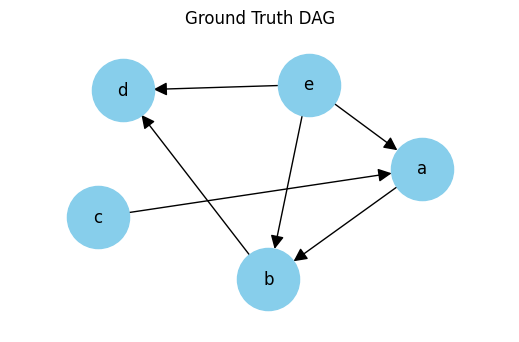

In [3]:
# visualise ground truth DAG
from mcmc.utils.graph_utils import plot_graph_from_adj_mat
plot_graph_from_adj_mat(synthetic_data.adj_mat.values, node_labels, title="Ground Truth DAG")

In [4]:
synthetic_data.data

,a,b,c,d,e
0,-3.072168,5.050093,-1.375524,11.271387,-0.679282
1,-1.951311,2.758978,-0.762411,7.909716,-0.341162
2,-0.270811,-1.801810,0.447882,-3.328167,-0.553230
3,-5.657454,5.139803,0.071720,13.916534,-2.591333
4,-3.076210,3.198327,-1.769963,6.070460,-0.678972
...,...,...,...,...,...
195,-4.258361,2.844093,0.547966,10.973635,-2.337592
196,0.182488,-4.770929,0.599925,-8.856835,-0.635323
197,-2.095682,1.471354,0.148852,5.995871,-1.294540
198,1.752877,0.001644,-1.071675,-0.670027,1.339787


In [5]:
# setup random initial graph

initial_graph = np.random.choice([0,1], size=(num_nodes, num_nodes))*np.tri(num_nodes, num_nodes, -1)
p = np.random.permutation(num_nodes)
# shuffle
initial_graph = initial_graph[p, :]
initial_graph = initial_graph[:, p]

In [6]:
# setup mcmc
from mcmc.utils.partition_utils import build_partition

n_iterations = 300000
score = BGeScore(synthetic_data.data, initial_graph)

partition = build_partition(incidence=initial_graph, node_labels=list(synthetic_data.data.columns))
proposal = PartitionProposal(partition)

M = PartitionMCMC(init_part=partition, max_iter=10000, proposal_object=proposal, score_object=score)

In [7]:
# run experiment

mcmc_results, acceptance = M.run()
graphs = M.get_mcmc_res_graphs(mcmc_results)
print('Acceptance_ratio:', acceptance)

Initialise:  0.00000
Acceptance_ratio: 0.1054


In [8]:
from mcmc.utils.graph_utils import generate_key_from_adj_matrix

BURN_IN = 0

graphs = M.get_mcmc_res_graphs(mcmc_results)

key = generate_key_from_adj_matrix(synthetic_data.adj_mat.values)
keys, counts = np.unique([generate_key_from_adj_matrix(g) for g in graphs[int(BURN_IN*len(graphs)):]], return_counts=True)
print(key in keys)

True


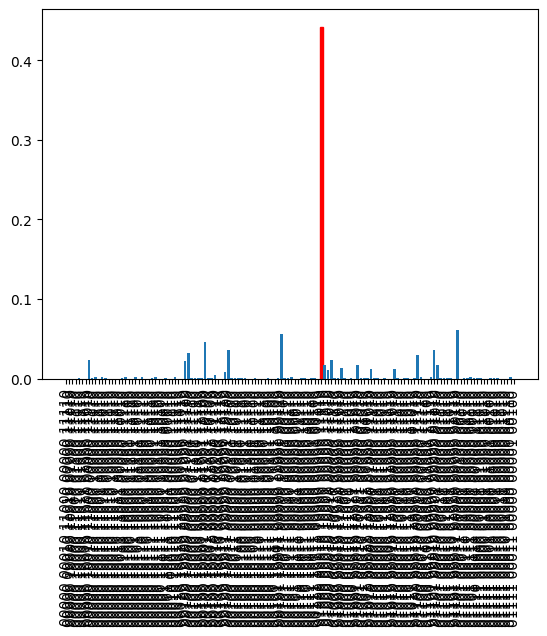

In [9]:
from matplotlib import pyplot as plt

bars = plt.bar(range(len(keys)), counts/len(graphs))
plt.xticks(range(len(keys)), keys, rotation=90);
bars[np.where(keys==key)[0][0]].set_color('red')

-1474.4710742622678


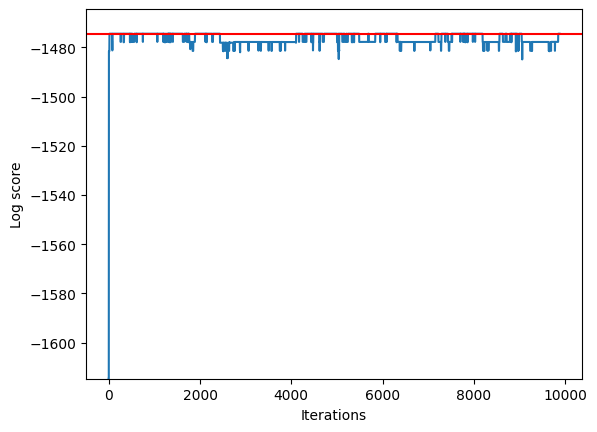

In [10]:
from mcmc.utils.partition_utils import convert_partition_to_party_permy_posy
from mcmc.utils.score_utils import partition_score

def get_mcmc_scores(results):
        mcmc_graph_lst = []
        for i in results:
            mcmc_graph_lst.append( results[i]['score_P_curr'] )
        return mcmc_graph_lst
scores = get_mcmc_scores(mcmc_results)

true_partition = build_partition(incidence=synthetic_data.adj_mat.values, node_labels=list(synthetic_data.data.columns))
party_curr, permy_curr, posy_curr = convert_partition_to_party_permy_posy(true_partition)
true_score = partition_score(M.node_labels, M.node_labels, M.parent_table, M.score_table, permy_curr, party_curr, posy_curr )
true_score = sum(true_score['total_scores'].values())
plt.plot(range(len(scores)), scores)
plt.axhline(true_score, color='r')
plt.ylim(min(scores), true_score+10)
plt.xlabel('Iterations')
plt.ylabel('Log score')
print(true_score)

In [11]:
from mcmc.evaluation.metrics import kl_divergence, jensen_shannon_divergence, mean_squared_error, mean_absolute_error
from mcmc.inference.posterior import generate_all_dags_keys, generate_all_dags

all_dags = generate_all_dags(data=synthetic_data.data, my_score=BGeScore)


Total 5 node DAGs generated = 29281


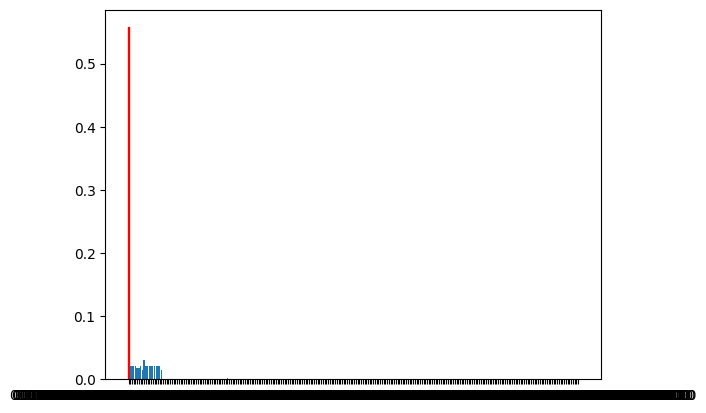

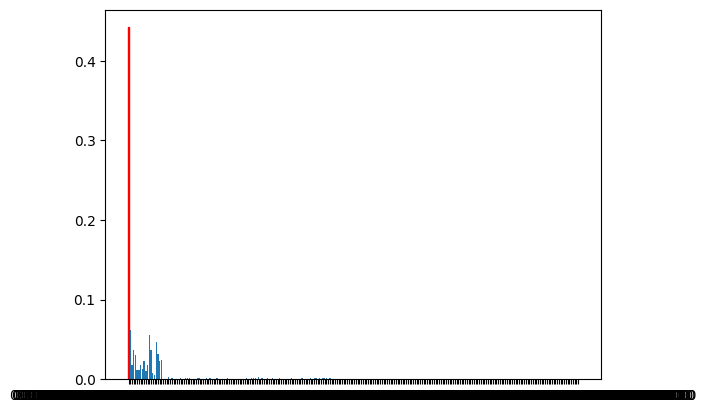

In [12]:

from mcmc.inference.posterior import compute_true_distribution

true_distribution = compute_true_distribution(all_dags)
dst = {key:count/sum(counts) for key, count in zip(keys, counts)}
approx_distribution = {key: (dst[key] if key in dst else 0) for key in true_distribution.keys()}

threshold = 1e-5
k = list(true_distribution.keys())
for _k in k:
    if true_distribution[_k] < threshold and approx_distribution[_k] < threshold:
        del true_distribution[_k]
        del approx_distribution[_k]
k = np.array(list(true_distribution.keys()))
bars = plt.bar(k, true_distribution.values())
# print(k, key)
bars[np.where(k==key)[0][0]].set_color('red')
plt.figure()
bars = plt.bar(approx_distribution.keys(), approx_distribution.values())
bars[np.where(k==key)[0][0]].set_color('red')

In [13]:
from mcmc.evaluation.metrics import mean_squared_error, mean_absolute_error, kl_divergence, jensen_shannon_divergence

print('KL div', kl_divergence(true_distribution, approx_distribution))
print('JS div', jensen_shannon_divergence(true_distribution, approx_distribution))
print('MSE', mean_squared_error(true_distribution, approx_distribution))
print('MAE', mean_absolute_error(true_distribution, approx_distribution))

KL div 0.45718848930299816
JS div 0.0351200182625709
MSE 7.113725961339946e-05
MAE 0.001552834099509559
